# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



In [1]:
import zipfile
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
zipcode_shape = gp.read_file('nyc-zip-code-tabulation-areas-polygons.geojson')
zipcode_shape.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [3]:
zipcode_shape.columns

Index(['@id', 'BLDGpostalCode', 'CTY_FIPS', 'OBJECTID', 'PO_NAME', 'STATE',
       'ST_FIPS', 'Shape_Area', 'Shape_Leng', 'borough', 'geometry',
       'postalCode'],
      dtype='object')

In [4]:
zipcode_shape = zipcode_shape.drop(['@id','BLDGpostalCode','CTY_FIPS','ST_FIPS',
                                    'OBJECTID','Shape_Area','Shape_Leng']
                                   , axis = 1)
zipcode_shape = zipcode_shape.rename(columns={'postalCode' : 'zip'})
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [5]:
zipcode_shape['zip'] = pd.to_numeric(zipcode_shape['zip'])
zipcode_shape['zip']

0      11372
1      11004
2      11040
3      11426
4      11365
5      11373
6      11001
7      11375
8      11427
9      11374
10     11366
11     11423
12     11428
13     11432
14     11379
15     11429
16     11435
17     11415
18     11418
19     11433
20     11451
21     11221
22     11421
23     11419
24     11434
25     11216
26     11416
27     11233
28     11436
29     11213
       ...  
232    10106
233    10158
234    10041
235    10120
236    10278
237    10155
238    10022
239    10043
240    10081
241    10096
242    10097
243    10196
244    10196
245    10275
246    10265
247    10045
248    10047
249    10047
250    10080
251    10203
252    10259
253    10260
254    10285
255    10286
256    11370
257    10065
258    10075
259    10069
260    10281
261    10282
Name: zip, dtype: int64

In [6]:
year = []
for i in range(94, 100, 1):
    year.append(str(i))
for i in range(0, 10, 1):
    year.append('0'+str(i))
for i in range(10, 15, 1):
    year.append(str(i))

### Reading datafiles

In [7]:
for i in year:
    zf = zipfile.ZipFile('zbp'+ i +'totals.zip')
    business_data = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    print("Year "+str(i)+'\n')
    print(business_data.head())
    print('\n')

Year 94

    zip         name empflag   emp    qp1      ap  est
0  1001   Agawam, MA     NaN  6198  33601  155158  439
1  1002  Amherst, MA     NaN  6073  28924  127367  450
2  1003  Amherst, MA     NaN    68    367    1604   10
3  1004  Amherst, MA     NaN   210    844    4302   47
4  1005    Barre, MA     NaN   678   3010   13521   92


Year 95

    zip             name empflag   emp    qp1      ap  est
0   501   Holtsville, NY       B     0      0       0    2
1  1000  Springfield, MA     NaN    49    529    2127    4
2  1001       Agawam, MA     NaN  5920  32993  152512  439
3  1002      Amherst, MA     NaN  6153  31645  132699  467
4  1003      Amherst, MA     NaN    89    380    1698   10


Year 96

    zip             name empflag   emp    qp1      ap  est
0   501   Holtsville, NY       B     0      0       0    4
1  1000  Springfield, MA     NaN   161   1494    6671   11
2  1001       Agawam, MA     NaN  6130  37746  171045  433
3  1002      Amherst, MA     NaN  6441  32964  14

In [8]:
for i in year:
    zf = zipfile.ZipFile('zbp'+i+'totals.zip')
    temp = pd.read_csv(zf.open('zbp'+i+'totals.zip'.replace('.zip','.txt')))
    temp.columns = map(str.lower, temp.columns)
    temp = temp[['zip', 'est']]
    temp.rename(columns={'est' : 'est'+str(i)}, inplace=True)
    zipcode_shape = zipcode_shape.merge(temp, on = 'zip', how = 'inner')

In [9]:
zipcode_shape.shape

(243, 26)

In [10]:
zipcode_shape.columns

Index(['PO_NAME', 'STATE', 'borough', 'geometry', 'zip', 'est94', 'est95',
       'est96', 'est97', 'est98', 'est99', 'est00', 'est01', 'est02', 'est03',
       'est04', 'est05', 'est06', 'est07', 'est08', 'est09', 'est10', 'est11',
       'est12', 'est13', 'est14'],
      dtype='object')

In [11]:
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip,est94,est95,est96,est97,est98,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,1229,1236,1292,1309,1351,...,1539,1527,1545,1538,1572,1629,1647,1724,1759,1768
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,194,188,176,192,194,...,225,226,238,227,233,229,222,241,241,250
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,1422,1414,1335,1344,1344,...,1441,1454,1488,1503,1475,1494,1488,1510,1539,1534
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,326,219,209,198,203,...,226,226,228,226,237,248,256,266,258,260
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,492,476,483,522,509,...,604,608,617,616,628,643,677,679,714,731


#### Whitening the data

In [12]:
est_mean = zipcode_shape.iloc[:,range(5,26)].mean(axis = 1)
est_std = zipcode_shape.iloc[:,range(5,26)].std(axis = 1)
zipcode_shape.iloc[:,range(5,26)] = zipcode_shape.iloc[:,range(4,26)].apply(lambda x: (x- est_mean) / est_std)
zipcode_shape.head()

,PO_NAME,STATE,borough,geometry,zip,est94,est95,est96,est97,est98,...,est05,est06,est07,est08,est09,est10,est11,est12,est13,est14
0,Jackson Heights,NY,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372,-1.650515,-1.607088,-1.259673,-1.154208,-0.893647,...,0.272673,0.198227,0.309896,0.266469,0.477400,0.831018,0.942687,1.420382,1.637516,1.693350
1,Glen Oaks,NY,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004,-0.974535,-1.248013,-1.794968,-1.065695,-0.974535,...,0.438432,0.484012,1.030967,0.529592,0.803069,0.620751,0.301694,1.167706,1.167706,1.577923
2,New Hyde Park,NY,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040,-0.118051,-0.234030,-1.379327,-1.248850,-1.248850,...,0.157401,0.345867,0.838780,1.056241,0.650313,0.925765,0.838780,1.157723,1.578149,1.505662
3,Bellerose,NY,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426,3.212291,-0.444253,-0.785986,-1.161892,-0.991026,...,-0.205040,-0.205040,-0.136693,-0.205040,0.170867,0.546773,0.820159,1.161892,0.888506,0.956853
4,Fresh Meadows,NY,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365,-1.332578,-1.549090,-1.454366,-0.926619,-1.102534,...,0.183004,0.237132,0.358920,0.345388,0.507772,0.710751,1.170839,1.197903,1.671522,1.901566


In [13]:
zipcode_shape.columns

Index(['PO_NAME', 'STATE', 'borough', 'geometry', 'zip', 'est94', 'est95',
       'est96', 'est97', 'est98', 'est99', 'est00', 'est01', 'est02', 'est03',
       'est04', 'est05', 'est06', 'est07', 'est08', 'est09', 'est10', 'est11',
       'est12', 'est13', 'est14'],
      dtype='object')

In [14]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

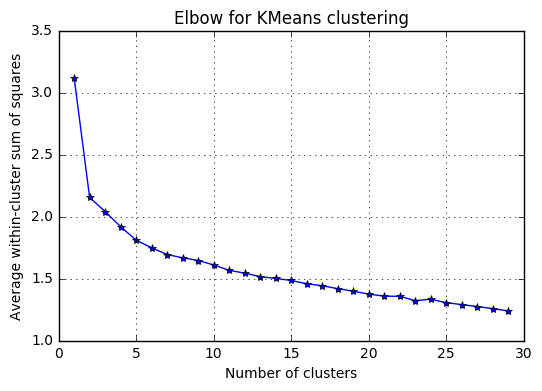

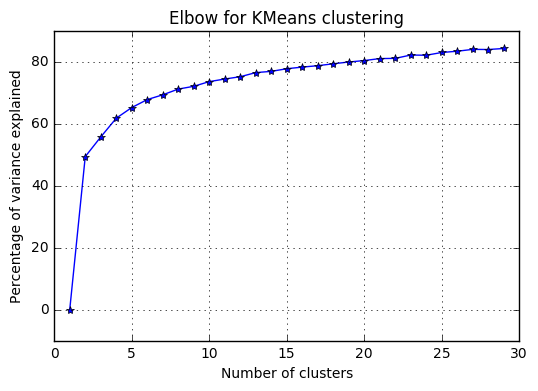

In [15]:
elbow(zipcode_shape.iloc[:, range(5,26)], range(1,30))

In [16]:
X=zipcode_shape.iloc[:, range(5,26)]
range_n_clusters = range(2,10)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =2, the average silhouette_score is :0.5721428017768126
For n_clusters =3, the average silhouette_score is :0.54143502020183
For n_clusters =4, the average silhouette_score is :0.49560155046341514
For n_clusters =5, the average silhouette_score is :0.47880135196509993
For n_clusters =6, the average silhouette_score is :0.23425277922480417
For n_clusters =7, the average silhouette_score is :0.2696532126413376
For n_clusters =8, the average silhouette_score is :0.14085788910009286
For n_clusters =9, the average silhouette_score is :0.20686549318997804


In [17]:
mod_km_2 = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                verbose=0, random_state=None).fit(X)

In [18]:
centers_2 = mod_km_2.cluster_centers_

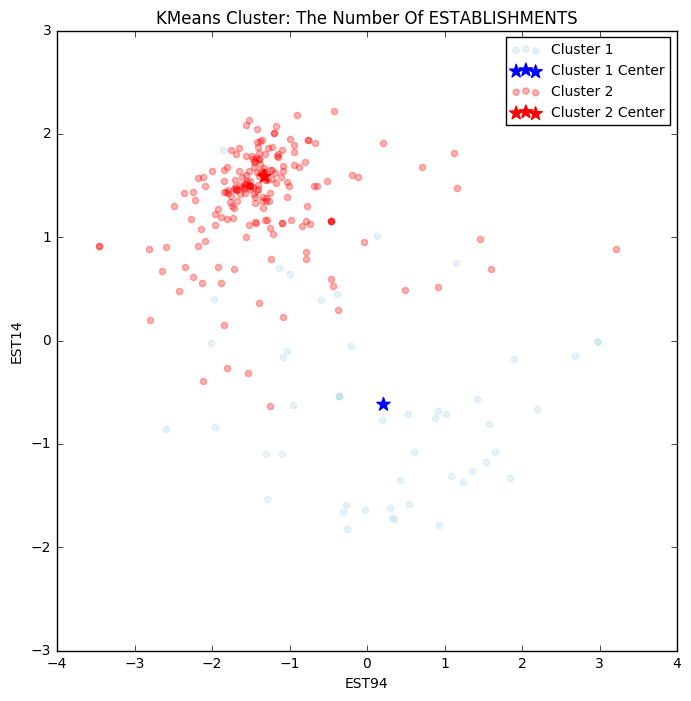

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(zipcode_shape[mod_km_2.labels_ == 0].iloc[:,5], zipcode_shape[mod_km_2.labels_ == 0].iloc[:,24], \
           color='lightblue', alpha=0.3, label="Cluster 1")
plt.scatter(centers_2[0][0], centers_2[0][-1], marker='*', s=100, color='blue', label="Cluster 1 Center")

plt.scatter(zipcode_shape[mod_km_2.labels_ == 1].iloc[:,5], zipcode_shape[mod_km_2.labels_ == 1].iloc[:,24], \
           color='red', alpha=0.3, label="Cluster 2")
plt.scatter(centers_2[1][0], centers_2[1][-1], marker='*', s=100, color='red', label="Cluster 2 Center")

plt.xlabel("EST94")
plt.ylabel("EST14")
plt.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
plt.legend(fontsize=10, loc='best')

In [20]:
#KMeans cluster
kmeans_cluster = KMeans(2).fit(zipcode_shape.iloc[:, range(5,26)])
centers = kmeans_cluster.cluster_centers_
zipcode_shape['km_labels'] = kmeans_cluster.labels_

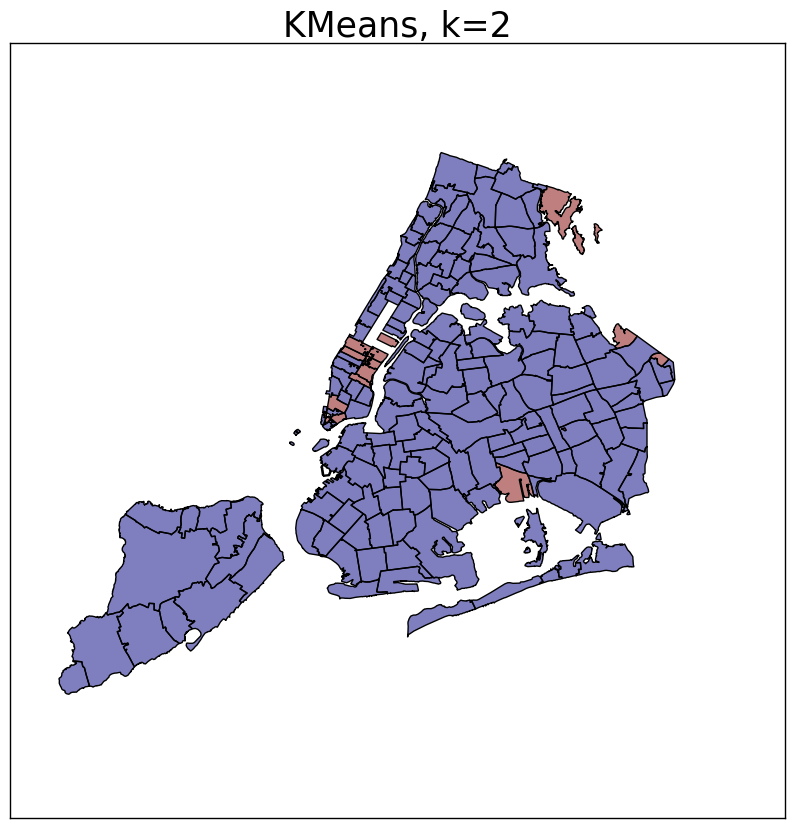

In [21]:
#Plotting KMeans cluster spatially
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape.plot(cmap='jet', column='km_labels', ax=ax, categorical=True, k=2)
ax.set_title("KMeans, k=2", fontsize=25)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#### 

In [22]:
mod_km_3 = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                verbose=0, random_state=None).fit(X)

In [23]:
centers_3 = mod_km_3.cluster_centers_

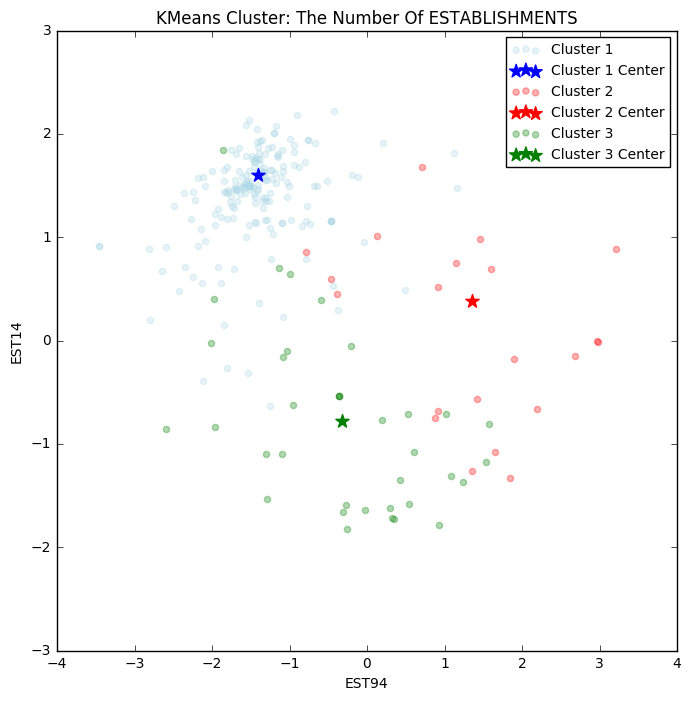

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(zipcode_shape[mod_km_3.labels_ == 0].iloc[:,5], zipcode_shape[mod_km_3.labels_ == 0].iloc[:,24], \
           color='lightblue', alpha=0.3, label="Cluster 1")
plt.scatter(centers_3[0][0], centers_3[0][-1], marker='*', s=100, color='blue', label="Cluster 1 Center")

plt.scatter(zipcode_shape[mod_km_3.labels_ == 1].iloc[:,5], zipcode_shape[mod_km_3.labels_ == 1].iloc[:,24], \
           color='red', alpha=0.3, label="Cluster 2")
plt.scatter(centers_3[1][0], centers_3[1][-1], marker='*', s=100, color='red', label="Cluster 2 Center")

plt.scatter(zipcode_shape[mod_km_3.labels_ == 2].iloc[:,5], zipcode_shape[mod_km_3.labels_ == 2].iloc[:,24], \
           color='green', alpha=0.3, label="Cluster 3")
plt.scatter(centers_3[2][0], centers_3[2][-1], marker='*', s=100, color='green', label="Cluster 3 Center")

plt.xlabel("EST94")
plt.ylabel("EST14")
plt.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
plt.legend(fontsize=10, loc='best')

In [25]:
#KMeans cluster
kmeans_cluster = KMeans(3).fit(zipcode_shape.iloc[:, range(5,26)])
centers = kmeans_cluster.cluster_centers_
zipcode_shape['km_labels'] = kmeans_cluster.labels_

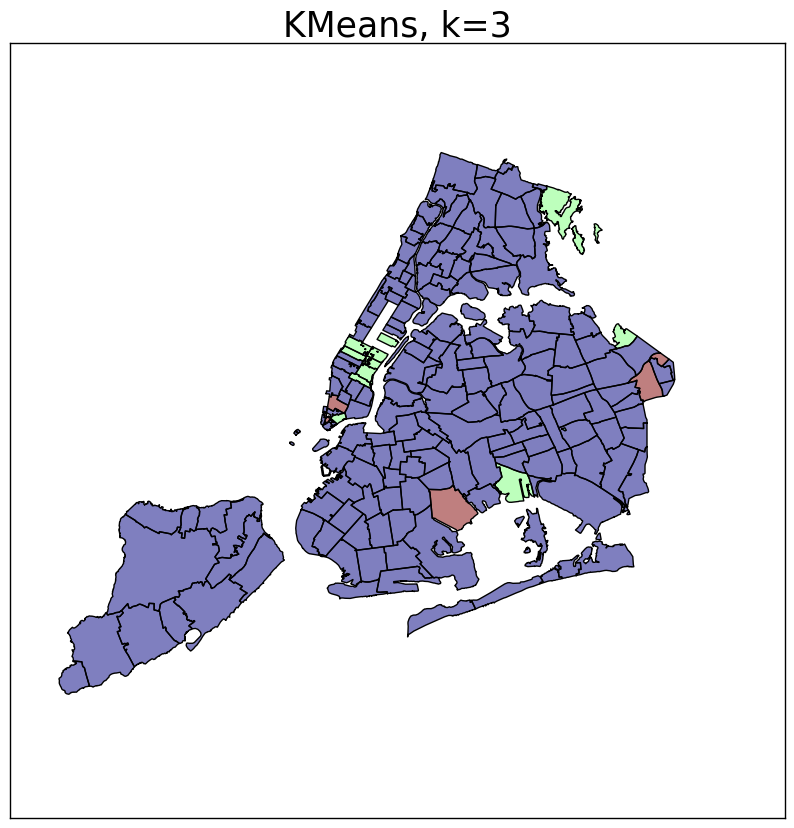

In [26]:
#Plotting KMeans cluster spatially
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape.plot(cmap='jet', column='km_labels', ax=ax, categorical=True, k=3)
ax.set_title("KMeans, k=3", fontsize=25)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

In [27]:
mod_km_4 = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                verbose=0, random_state=None).fit(X)

In [28]:
centers_4 = mod_km_4.cluster_centers_

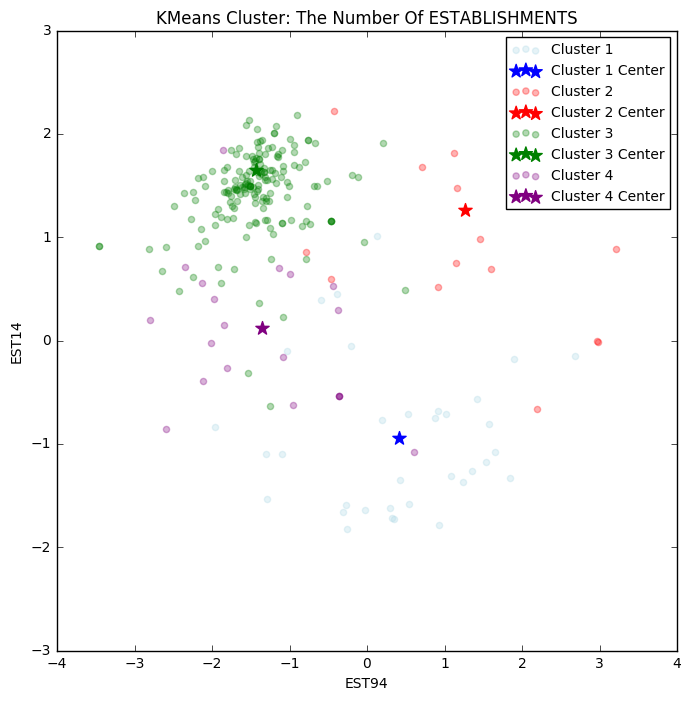

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(zipcode_shape[mod_km_4.labels_ == 0].iloc[:,5], zipcode_shape[mod_km_4.labels_ == 0].iloc[:,24], \
           color='lightblue', alpha=0.3, label="Cluster 1")
plt.scatter(centers_4[0][0], centers_4[0][-1], marker='*', s=100, color='blue', label="Cluster 1 Center")

plt.scatter(zipcode_shape[mod_km_4.labels_ == 1].iloc[:,5], zipcode_shape[mod_km_4.labels_ == 1].iloc[:,24], \
           color='red', alpha=0.3, label="Cluster 2")
plt.scatter(centers_4[1][0], centers_4[1][-1], marker='*', s=100, color='red', label="Cluster 2 Center")

plt.scatter(zipcode_shape[mod_km_4.labels_ == 2].iloc[:,5], zipcode_shape[mod_km_4.labels_ == 2].iloc[:,24], \
           color='green', alpha=0.3, label="Cluster 3")
plt.scatter(centers_4[2][0], centers_4[2][-1], marker='*', s=100, color='green', label="Cluster 3 Center")

plt.scatter(zipcode_shape[mod_km_4.labels_ == 3].iloc[:,5], zipcode_shape[mod_km_4.labels_ == 3].iloc[:,24], \
           color='purple', alpha=0.3, label="Cluster 4")
plt.scatter(centers_4[3][0], centers_4[3][-1], marker='*', s=100, color='purple', label="Cluster 4 Center")

plt.xlabel("EST94")
plt.ylabel("EST14")
plt.title("KMeans Cluster: The Number Of ESTABLISHMENTS")
plt.legend(fontsize=10, loc='best')

In [30]:
#KMeans cluster
kmeans_cluster = KMeans(4).fit(zipcode_shape.iloc[:, range(5,26)])
centers = kmeans_cluster.cluster_centers_
zipcode_shape['km_labels'] = kmeans_cluster.labels_

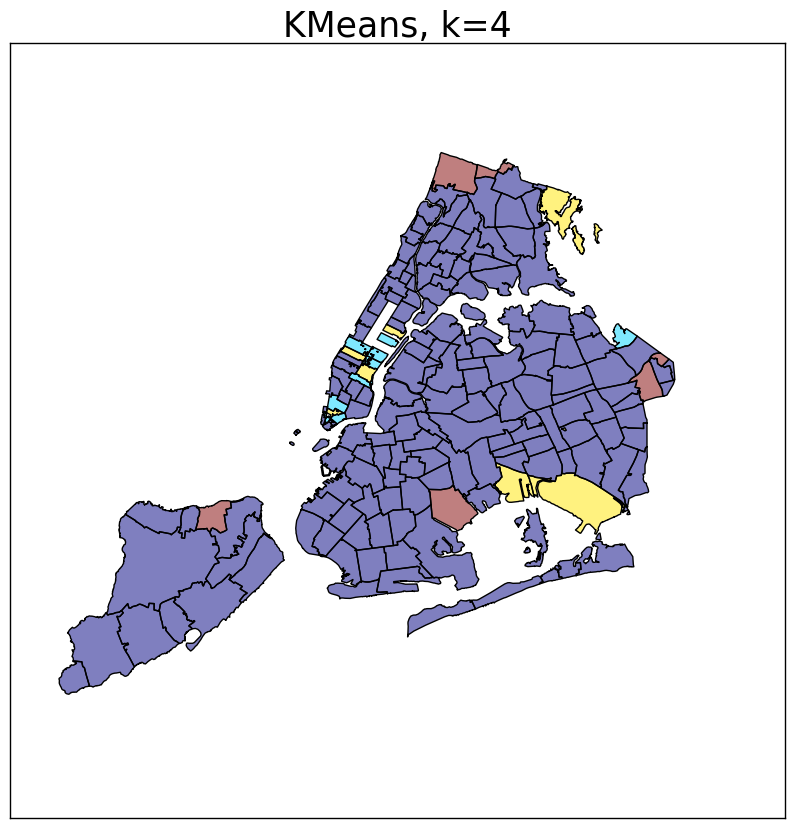

In [31]:
#Plotting KMeans cluster spatially
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape.plot(cmap='jet', column='km_labels', ax=ax, categorical=True, k=4)
ax.set_title("KMeans, k=4", fontsize=25)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

In [32]:
Z = linkage(zipcode_shape.iloc[:,range(5,26)], 'ward')

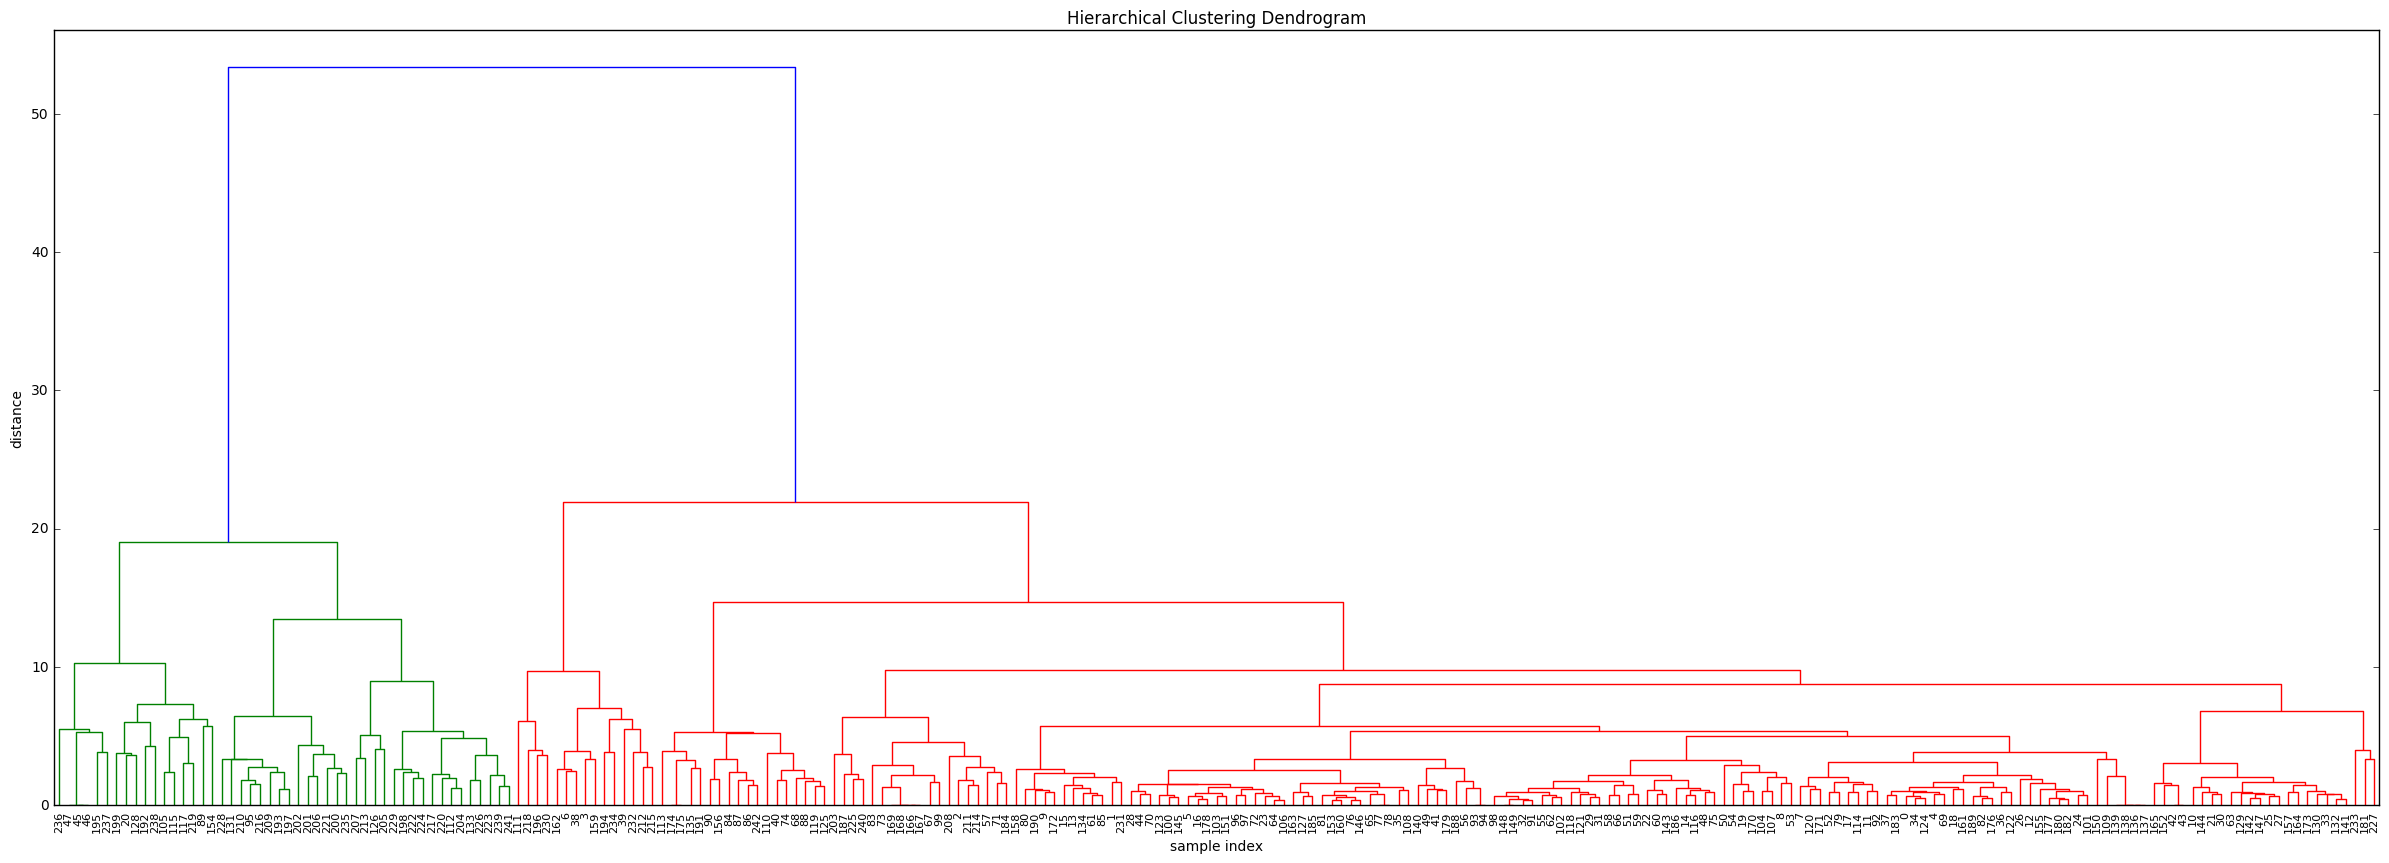

In [33]:
plt.figure(figsize=(30,10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [34]:
HC_label = fcluster(Z, 4, criterion='maxclust')

In [35]:
zipcode_shape_2 = zipcode_shape.copy()
zipcode_shape_2['HC'] = HC_label
zipcode_shape_2['HC_'] = zipcode_shape_2.HC.replace([1,4],[4,1])

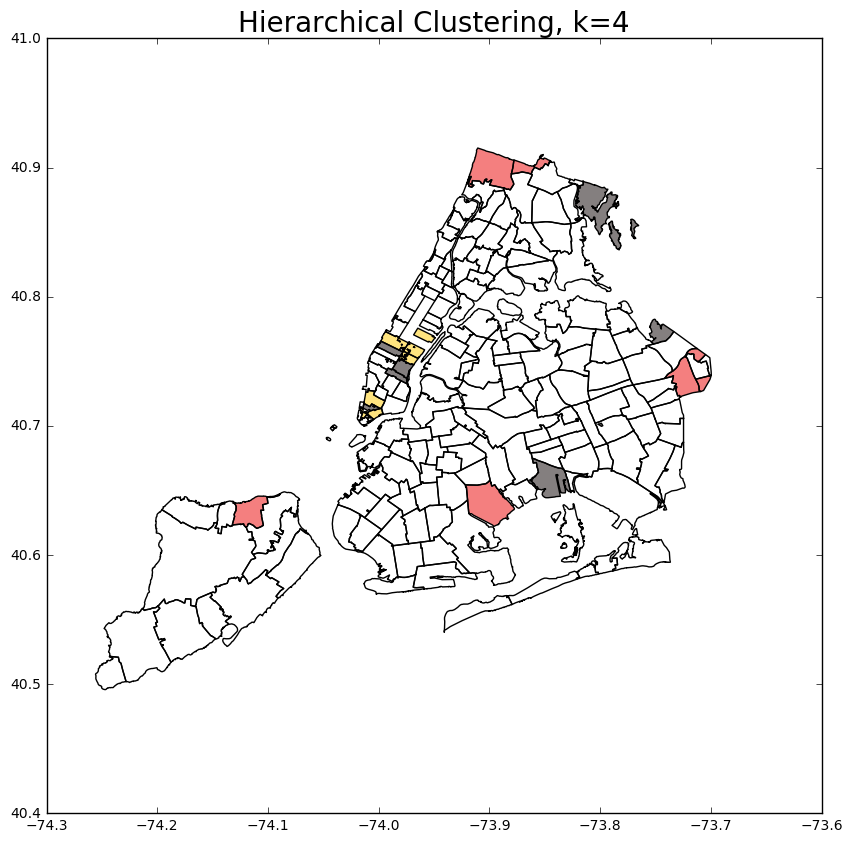

In [36]:
f, ax = plt.subplots(figsize=(10,10))
zipcode_shape_2.plot(cmap='hot_r', column='HC_', ax=ax, categorical=True, k=4)
ax.set_title("Hierarchical Clustering, k=4", fontsize=20)

In [ ]:
#@Review: Interpret you results and compare the the two algorithms!

# NYC zip codes shape file is here
## http://data.nycprepared.org/dataset/nyc-zip-code-tabulation-areas/resource/0c0e14e9-78e1-404e-97b0-c2fabceb3981

This website id currently down. I uploaded the geojson file in the github repo as well

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

The map of the clusters may look something like this